In [1]:
# Hide warnings on Jupyter Notebook
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import os
import gc
import glob
import numpy as np
import platform

#this is what makes the plots transparent in notebooks
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot

from keras.models import load_model
# from tensorflow.keras.models import load_model

from vis.visualization import visualize_saliency
from vis.visualization import visualize_cam
from vis.utils import utils
from keras import activations

from sklearn.externals import joblib

import subprocess
import shutil
from PIL import Image
import time

from scipy import stats

Using TensorFlow backend.
/home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
img_size = 224
extra = 'big'
# img_size = 180
# img_size = 512
# model = load_model('model_0.h5')
if (platform.system() == "Windows"):
    model = load_model(os.path.join(os.getcwd(), '..', 'model.h5'))
else:
    # model = load_model(os.path.join(os.getcwd(), 'model.h5'))
    model = load_model(os.path.join(os.getcwd(), '..', 'model_{}_{}.h5'.format(img_size, extra)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)       295168    
__________

In [3]:
# print([layer.name for layer in model.get_layer('vgg16').layers])
# for layer in model.layers:
#     print(layer.name)
all_layer_names = [layer.name for layer in model.layers]
print(all_layer_names)

['conv2d_1', 'conv2d_2', 'max_pooling2d_1', 'conv2d_3', 'conv2d_4', 'max_pooling2d_2', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'max_pooling2d_3', 'conv2d_8', 'conv2d_9', 'conv2d_10', 'max_pooling2d_4', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'max_pooling2d_5', 'flatten_1', 'dense_1', 'dense_2', 'dense_3']


In [4]:
print(all_layer_names[-1])
print(utils.find_layer_idx(model, all_layer_names[-1]))

dense_3
21


In [5]:
if (platform.system() == "Windows"):
    render_folder = os.path.join(os.getcwd(), "..","greebles_10") #reduced dataset of 10
else:
    # render_folder = os.path.join(os.getcwd(),"greebles_10") #reduced dataset of 10
    render_folder = os.path.join(os.getcwd(), "..", "greebles_10") 

set_mode = 'specific_all'
set_type = 'specific_angle'
source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)

test_set_name = "greebles10_test_-90_90_1_{}.npy".format(img_size)
# test_set_name = "greebles10_upsidedown_-90_90_1_{}.npy".format(img_size)

labels = {0: 'f-1', 1: 'f-2', 2: 'f-3', 3: 'f-4', 4: 'f-5', 5: 'm-1', 6: 'm-2', 7: 'm-3', 8: 'm-4', 9: 'm-5'}
test_set_path = os.path.join(source_folder, test_set_name)
# all_test = np.load(test_set_path, allow_pickle=True).item()
all_test = joblib.load(test_set_path)

(10, 224, 224, 1)


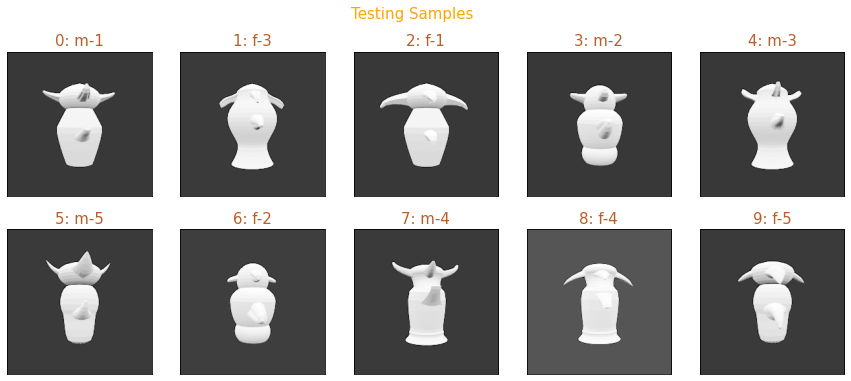

In [6]:
# Display one specific angle just as an example of what images are we using
angle_used = '10'
(x_test, y_test) = np.copy(all_test[angle_used][0]), np.copy(all_test[angle_used][1])
# Make background the same color
# x_test[x_test < 70] = 0
x_test *= (1.0/255)
print(x_test.shape)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i][:,:,0], cmap='Greys_r')
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=labels[int(true_label)], number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

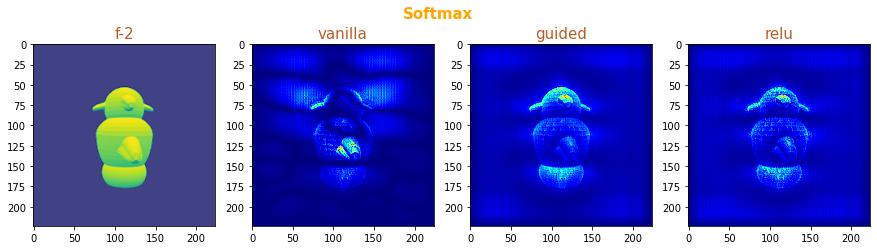

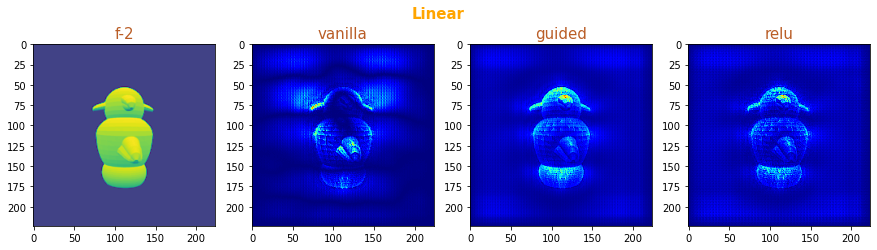

In [7]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
# layer_idx = utils.find_layer_idx(model, 'dense_2')
layer_idx = utils.find_layer_idx(model, all_layer_names[-1])

# Example saliency visualization
class_idx = 1
indices = np.where(y_test[:, class_idx] == 1.)[0]
idx = indices[0] # pick some random input from here.

# Remove eventually to speed up
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

fig, ax = plt.subplots(1, 4, figsize=(15,6))
ax[0].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
ax[0].imshow(x_test[idx][..., 0])

for i, modifier in enumerate([None, 'guided', 'relu']):
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=x_test[idx], backprop_modifier=modifier)
    if modifier == None:
        modifier = 'vanilla'
    ax[i+1].set_title(modifier, color='#ba5e27', fontsize=15)
    ax[i+1].imshow(grads, cmap='jet')
fig.suptitle('Softmax', fontsize=15, color='orange', fontweight ="bold", y=0.8)
#############################################
# Swap softmax with linear for better results
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

fig, ax = plt.subplots(1, 4, figsize=(15,6))
ax[0].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
ax[0].imshow(x_test[idx][..., 0])

for i, modifier in enumerate([None, 'guided', 'relu']):
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=x_test[idx], backprop_modifier=modifier)
    if modifier == None:
        modifier = 'vanilla'
    ax[i+1].set_title(modifier, color='#ba5e27', fontsize=15)
    ax[i+1].imshow(grads, cmap='jet')
fig.suptitle('Linear', fontsize=15, color='orange', fontweight ="bold", y=0.8)

plt.show()

In [8]:
# # Remove eventually to speed up
# model.layers[layer_idx].activation = activations.softmax
# model = utils.apply_modifications(model)
# fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
# ax = ax.ravel()
# for class_idx in range(10):    
#     indices = np.where(y_test[:, class_idx] == 1.)[0]
#     idx = indices[0]

#     offset = class_idx*4
#     ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
#     ax[offset].imshow(x_test[idx][..., 0])
#     ax[offset].set_yticklabels([])
#     ax[offset].set_xticklabels([])
#     ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
#     for i, modifier in enumerate([None, 'guided', 'relu']):
#         grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
#                                    seed_input=x_test[idx], backprop_modifier=modifier)
#         if modifier is None:
#             modifier = 'vanilla'
#         ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
#         ax[offset+i+1].imshow(grads, cmap='jet')
#         ax[offset+i+1].set_yticklabels([])
#         ax[offset+i+1].set_xticklabels([])
#         ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# # Clear memory
# plt.show()
# fig.clf()
# plt.close(fig)
# gc.collect()

# model.layers[layer_idx].activation = activations.linear
# model = utils.apply_modifications(model)

In [9]:
# # This corresponds to the Dense linear layer.
# model.layers[layer_idx].activation = activations.linear
# model = utils.apply_modifications(model)
# fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
# ax = ax.ravel()
# for class_idx in range(10):    
#     indices = np.where(y_test[:, class_idx] == 1.)[0]
#     idx = indices[0]

#     offset = class_idx*4
#     ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
#     ax[offset].imshow(x_test[idx][..., 0])
#     ax[offset].set_yticklabels([])
#     ax[offset].set_xticklabels([])
#     ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
#     for i, modifier in enumerate([None, 'guided', 'relu']):
#         grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
#                                    seed_input=x_test[idx], backprop_modifier=modifier)
#         if modifier is None:
#             modifier = 'vanilla'
#         ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
#         ax[offset+i+1].imshow(grads, cmap='jet')
#         ax[offset+i+1].set_yticklabels([])
#         ax[offset+i+1].set_xticklabels([])
#         ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# # test_set_name
# # Clear memory
# plt.show()
# fig.clf()
# plt.close(fig)
# gc.collect()

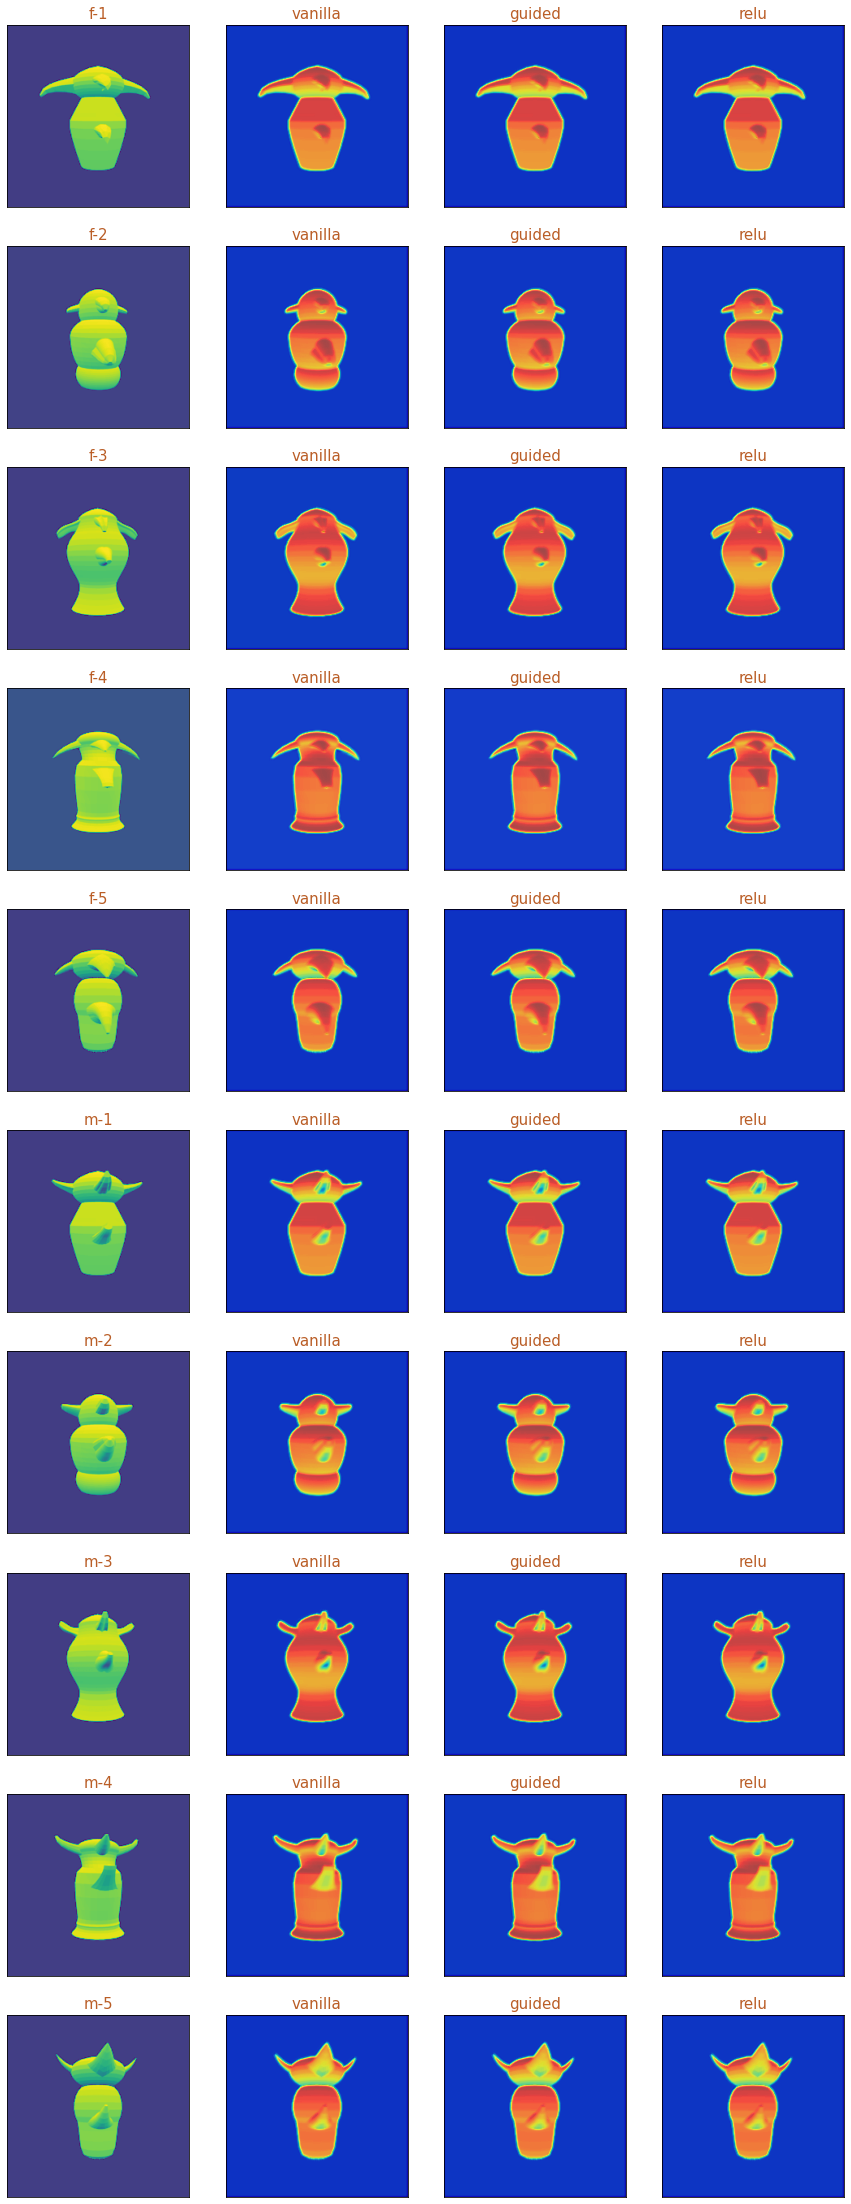

15963

In [10]:
# # Swap softmax with linear
# model.layers[layer_idx].activation = activations.linear
# model = utils.apply_modifications(model)

# grad-CAM
# layer_idx = utils.find_layer_idx(model, 'dense_2')
layer_idx = utils.find_layer_idx(model, all_layer_names[-1])
# layer_idx = utils.find_layer_idx(model, 'conv2d_2')

penultimate_layer = utils.find_layer_idx(model, 'conv2d_2')
# penultimate_layer = utils.find_layer_idx(model, 'max_pooling2d_5')

fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
ax = ax.ravel()
for class_idx in range(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    offset = class_idx*4
    ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
    ax[offset].imshow(x_test[idx][..., 0])
    ax[offset].set_yticklabels([])
    ax[offset].set_xticklabels([])
    ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                                     seed_input=x_test[idx], backprop_modifier=modifier,
                                     penultimate_layer_idx=penultimate_layer)
        if modifier is None:
            modifier = 'vanilla'
            grads_vanilla = grads
        ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
        ax[offset+i+1].imshow(grads, cmap='jet')
        
        ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='gray', alpha=0.29)
        
        ax[offset+i+1].set_yticklabels([])
        ax[offset+i+1].set_xticklabels([])
        ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# Clear memory
plt.show()
fig.clf()
plt.close(fig)
gc.collect()

In [11]:
grads_vanilla

array([[0.00024377, 0.0567117 , 0.07765279, ..., 0.07765279, 0.07231052,
        0.00942645],
       [0.04903043, 0.14388947, 0.15724072, ..., 0.15724072, 0.13586439,
        0.0688533 ],
       [0.06791177, 0.16418831, 0.17941007, ..., 0.17941007, 0.1484575 ,
        0.07150292],
       ...,
       [0.06791177, 0.16418831, 0.17941007, ..., 0.17941007, 0.1484575 ,
        0.07150292],
       [0.06457756, 0.1448758 , 0.16181003, ..., 0.16181003, 0.12868626,
        0.05181856],
       [0.01768352, 0.0716918 , 0.08995092, ..., 0.08995092, 0.04763487,
        0.        ]], dtype=float32)

In [12]:
# # grad-CAM
# layer_idx = utils.find_layer_idx(model, 'dense_2')
# # layer_idx = utils.find_layer_idx(model, 'conv2d_2')

# # penultimate_layer = utils.find_layer_idx(model, 'conv2d_1')
# # penultimate_layer = utils.find_layer_idx(model, 'conv2d_12')
# penultimate_layer = utils.find_layer_idx(model, 'max_pooling2d_5')

# fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
# ax = ax.ravel()
# for class_idx in range(10):    
#     indices = np.where(y_test[:, class_idx] == 1.)[0]
#     idx = indices[0]

#     offset = class_idx*4
#     ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
#     ax[offset].imshow(x_test[idx][..., 0])
#     ax[offset].set_yticklabels([])
#     ax[offset].set_xticklabels([])
#     ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
#     for i, modifier in enumerate([None, 'guided', 'relu']):
#         grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
#                                      seed_input=x_test[idx], backprop_modifier=modifier,
#                                      penultimate_layer_idx=penultimate_layer)
#         if modifier is None:
#             modifier = 'vanilla'
#         ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
#         ax[offset+i+1].imshow(grads, cmap='jet')
        
#         ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='gray', alpha=0.29)
        
#         ax[offset+i+1].set_yticklabels([])
#         ax[offset+i+1].set_xticklabels([])
#         ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
    
# # Clear memory
# plt.show()
# fig.clf()
# plt.close(fig)
# gc.collect()

{0: 'f-1', 1: 'f-2', 2: 'f-3', 3: 'f-4', 4: 'f-5', 5: 'm-1', 6: 'm-2', 7: 'm-3', 8: 'm-4', 9: 'm-5'}
1
2


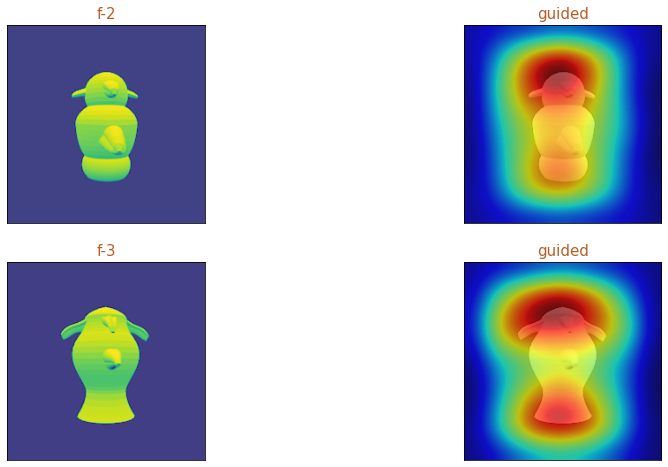

57973

In [13]:
# grad-CAM
# layer_idx = utils.find_layer_idx(model, 'dense_2')
layer_idx = utils.find_layer_idx(model, all_layer_names[-1])
pen_layer_name = 'max_pooling2d_5'
# penultimate_layer = utils.find_layer_idx(model, 'conv2d_2')
# penultimate_layer = utils.find_layer_idx(model, 'conv2d_13')
penultimate_layer = utils.find_layer_idx(model, pen_layer_name)

print(labels)
fig, ax = plt.subplots(2, 2, figsize=(15,4*2))
ax = ax.ravel()
counter = 0
for class_idx in range(1,3):
    print(class_idx)
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    # offset = class_idx*2
    offset = counter*2
    ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
    ax[offset].imshow(x_test[idx][..., 0])
    ax[offset].set_yticklabels([])
    ax[offset].set_xticklabels([])
    ax[offset].tick_params(axis=u'both', which=u'both', length=0)
    
    for i, modifier in enumerate(['guided']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                                     seed_input=x_test[idx], backprop_modifier=modifier,
                                     penultimate_layer_idx=penultimate_layer)
        if modifier is None:
            modifier = 'vanilla'
        ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
        ax[offset+i+1].imshow(grads, cmap='jet')
        
        ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='gray', alpha=0.29)
        
        ax[offset+i+1].set_yticklabels([])
        ax[offset+i+1].set_xticklabels([])
        ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)

        counter += 1
    
# Clear memory
plt.show()
fig.clf()
plt.close(fig)
gc.collect()

In [14]:
# # Change these as needed
# class_idx = 1
# indices = np.where(y_test[:, class_idx] == 1.)[0]
# idx = indices[0]
# # penultimate_layer = utils.find_layer_idx(model, 'conv2d_2')
# penultimate_layer = utils.find_layer_idx(model, 'conv2d_13')
# layer_idx = utils.find_layer_idx(model, 'dense_2')
# layer_idx = utils.find_layer_idx(model, all_layer_names[-1])

# grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
#                                      seed_input=x_test[idx], backprop_modifier='guided',
#                                      penultimate_layer_idx=penultimate_layer)

# im = plt.imshow(grads, cmap='jet', vmin=0, vmax=1)
# plt.colorbar(im, orientation='vertical')
# plt.imshow(x_test[idx][..., 0], cmap='gray', alpha=0.29)
# plt.show()

# ################################
# if (platform.system() == "Windows"):
#     blender_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\blender-2.78c-windows64"
#     blender_exec = os.path.join(blender_folder, 'blender.exe')
#     render_util_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\greebles-generator-master\adversarial-robustness-toolbox\my_scripts"
#     render_script = os.path.join(render_util_folder, 'render.py')
#     dataset_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\greebles-generator-master\Greebles_3DS_10"
# else:
#     blender_folder = r"/home/ec1018/projects/blender-2.78c-linux-glibc219-x86_64"
#     blender_exec = os.path.join(blender_folder, 'blender')
#     render_util_folder = os.getcwd()
#     render_script = os.path.join(render_util_folder, 'render.py')
#     dataset_folder = r"/home/ec1018/projects/Greebles_3DS_10"

# render_folder = os.path.join(os.getcwd(), "temp_heat_render")
# set_mode = 'specific_all'
# set_type = 'specific_angle'

# if os.path.exists(render_folder) and os.path.isdir(render_folder):
#     shutil.rmtree(render_folder)
# blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--',
#                     "--parts_remove", 
#                     "LEFT_EAR", 
#                     # "RIGHT_EAR", 
#                     # "BUMP", 
#                     # "BODY",
#                     '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
#                     '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', '0', '-zr', angle_used])
# # time.sleep(2)
# source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
# all_render_imgs = os.listdir(source_folder)
# all_render_imgs.sort()
# # print(all_render_imgs)
# file_name_idx = os.path.join(source_folder, all_render_imgs[class_idx])
# print(all_render_imgs[class_idx])
# ################
# nose = np.array(Image.open(file_name_idx).convert('L'), dtype='float64')
# # nose *= (1.0/255)
# # plt.imshow(grads, cmap='jet')
# # plt.imshow(nose, cmap='gray', alpha=0.29)
# # from scipy import stats
# # print(stats.mode(nose, axis=None)[0])
# bg_color = stats.mode(nose, axis=None)[0][0]
# print("bg_color:", bg_color)
# # part_location = np.where(nose != bg_color)
# part_location =  np.where(np.isclose(nose, bg_color) == False)
# background_location =  np.where(np.isclose(nose, bg_color) == True)
# # print(grads[23][23])
# plt.imshow(nose)
# plt.scatter(part_location[1], part_location[0], color='black')
# plt.show()

# total_pixel_area_body_part = part_location[0].shape[0]
# print(total_pixel_area_body_part)
# counter = 0
# for i in zip(part_location[0], part_location[1]):
#     if grads[i[0]][i[1]] >= 0.7:
#         counter += 1

# print("{:.2f}%".format( (counter/total_pixel_area_body_part) * 100))

# print("==============")
# # bg_color_grad = stats.mode(grads, axis=None)[0][0]
# # print("bg_color_grad:", bg_color_grad)

# # grads_part = np.take(grads, part_location) - bg_color_grad
# # sum_grads_part = np.sum(grads_part)
# # grads_part = grads_part/sum_grads_part
# # print("sum_grads_part", np.sum(grads_part))

# # grads_background = np.take(grads, background_location) - bg_color_grad
# # sum_grads_background = np.sum(grads_background)
# # grads_background = grads_background/sum_grads_background
# # print("grads_background:", 1 - np.sum(grads_background))

# # print("{:.2f}%".format( np.sum(grads_part) * 100))
# # display(background_location)
# print("==============")
# # grads = grads[10][10]
# sum_grads = np.sum(grads)
# grads = grads/sum_grads
# print(np.sum(grads))
# counter = 0
# for i in zip(part_location[0], part_location[1]):
#     counter += grads[i[0]][i[1]]
# print("{:.2f}%".format( (counter) * 100))

In [15]:
# # print(len(grads))
# # print(len(grads[0]))
# print(grads[0][0])
# print(grads[0][179])
# print(grads[10][10])
# print(grads[179][0])
# # print(grads[5][5])
# # print(grads[130][50])
# # print(grads / np.sum(grads))
# print(np.min(grads))
# print(np.max(grads))
# print(np.where(grads == 0.0))
# # def map_0_1(a):
# #     a_max = np.max(a)
# #     a_min = np.min(a)

# #     temp = []
# #     for i in a:
# #         for j in i:


In [16]:
# We have to do everything inside this loop, create video, etc
sal_dir = 'saliency_{}'.format(img_size)
os.makedirs(sal_dir, exist_ok=True)
for c, current_angle in enumerate(all_test.keys()):
    if os.path.exists("{}/{}_sal_{}.png".format(sal_dir, str(c).zfill(3), current_angle)):
        print("Skipped {}".format(current_angle))
        continue
    
    if (int(current_angle)%10) != 0: pass
    else:
        print(current_angle, end=", ")        
        (x_test, y_test) = np.copy(all_test[current_angle][0]), np.copy(all_test[current_angle][1])
        
        # Make background the same color
#         x_test[x_test < 70] = 0
        
        x_test *= (1.0/255)
        
        fig, ax = plt.subplots(10, 4, figsize=(15,4*10))
        ax = ax.ravel()
        for class_idx in range(10):
            indices = np.where(y_test[:, class_idx] == 1.)[0]
            idx = indices[0]

            offset = class_idx*4
            ax[offset].set_title(labels[class_idx], fontsize=15, color='#ba5e27')
            ax[offset].imshow(x_test[idx][..., 0])
            ax[offset].set_yticklabels([])
            ax[offset].set_xticklabels([])
            ax[offset].tick_params(axis=u'both', which=u'both', length=0)

            for i, modifier in enumerate([None, 'guided', 'relu']):
                grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                                             seed_input=x_test[idx], backprop_modifier=modifier,
                                             penultimate_layer_idx=penultimate_layer)
                if modifier is None:
                    modifier = 'vanilla'
                ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
                ax[offset+i+1].imshow(grads, cmap='jet')

                ax[offset+i+1].imshow(x_test[idx][..., 0], cmap='gray', alpha=0.29)

                ax[offset+i+1].set_yticklabels([])
                ax[offset+i+1].set_xticklabels([])
                ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
                
            # for i, modifier in enumerate([None, 'guided', 'relu',]):
            #     grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
            #                                seed_input=x_test[idx], backprop_modifier=modifier)
            #     if modifier is None:
            #         modifier = 'vanilla'
            #     ax[offset+i+1].set_title(modifier, color='#ba5e27', fontsize=15)
            #     ax[offset+i+1].imshow(grads, cmap='jet')
            #     ax[offset+i+1].set_yticklabels([])
            #     ax[offset+i+1].set_xticklabels([])
            #     ax[offset+i+1].tick_params(axis=u'both', which=u'both', length=0)
        
        fig.tight_layout(rect=[0, 0, 1, 0.97])
        st = fig.suptitle("{}°; {}; {}".format(current_angle, all_layer_names[-1], pen_layer_name), fontsize=20)
        # fig.subplots_adjust(top=0.95)
        plt.savefig("{}/{}_sal_{}.png".format(sal_dir, str(c).zfill(3), current_angle), bbox_extra_artists=[st], dpi=150, bbox_inches = "tight")
        
        # Clear memory
#         plt.show()
        fig.clf()
        fig.clear()
        plt.close(fig)
        gc.collect()
        # break

print("Done\n")
print(x_test.shape)
print(y_test.shape)

-90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, Done

(10, 224, 224, 1)
(10, 10)


In [17]:
import cv2

fps = 3
fp_in = "{}/*_sal_*.png".format(sal_dir)
fp_in_1 = "{}/000_sal_-90.png".format(sal_dir)
fp_out = "{}/animated_sal_{}fps.avi".format(sal_dir, fps)

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = [cv2.imread(f) for f in glob.glob(fp_in_1)]
height, width, layers = imgs[0].shape
print(height, width)
size = (width,height)
out = cv2.VideoWriter(fp_out,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

imgs = glob.glob(fp_in)
imgs.sort(key=os.path.getmtime)
for i in imgs:
    # writing to a image array
    out.write(cv2.imread(i))
out.release()

print("Done!")

5887 2224
Done!


In [18]:
# Clear allocated memory for the GPU
try:
    from numba import cuda
    cuda.select_device(0)
    cuda.close()
    print("Cleared memory")
except:
    print("Could not clear memory")

Cleared memory
